In [5]:
import Bio.SeqIO as SeqIO
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster as cluster
from tqdm import tqdm
import pywt
import matplotlib.pyplot as plt

shuffle = {}
with open("./ce1.fna", "r") as f:
    for record in SeqIO.parse(f,"fasta"):
        shuffle[record.id] = str(record.seq)

real = {}
O = 1000000
for k, v in shuffle.items():
    for i, p in enumerate(range(1, (len(v)//O)*O, O)):
        real[f"{k}_{i}"] = v[p:p+O]

l = list(real.items())
random.shuffle(l)
real = dict(l)

with open("./ce_shuffle.fna", "w") as f:
    for k, v in real.items():
        f.write(f">{k}\n{v}\n")

In [6]:
import itertools
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(itertools.islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [7]:
def count_kmers(read, k):
    """Count kmer occurrences in a given read.

    Parameters
    ----------
    read : string
        A single DNA sequence.
    k : int
        The value of k for which to count kmers.

    Returns
    -------
    counts : dictionary, {'string': int}
        A dictionary of counts keyed by their individual kmers (strings
        of length k).

    Examples
    --------
    >>> count_kmers("GATGAT", 3)
    {'ATG': 1, 'GAT': 2, 'TGA': 1}
    """
    # Start with an empty dictionary
    counts = {}
    nucleotides = ['A', 'T', 'G', 'C']
    # Add the kmer to the dictionary if it's not there
    for i in itertools.product(nucleotides, repeat=k):
        counts["".join(i)] = 0
    # Calculate how many kmers of length k there are
    num_kmers = len(read) - k + 1
    # Loop over the kmer start positions
    for kmer in window(read, n=k):
        kmer = "".join(kmer)
        if kmer not in counts:
            continue
        # Increment the count for this kmer
        counts[kmer] += 1
    # Return the final counts
    return counts

In [8]:
def dict2array(d):
    return list(d.values())

In [9]:
def shortest_key(d):
    return sorted([(len(v), k) for k, v in d.items()])[0][1]

In [16]:
L = 50000
data_ctg = {}
ctg_index = {}
data = {}

with open("./ce_shuffle.fna", "r") as f:
    for record in tqdm(SeqIO.parse(f, "fasta")):
        data_ctg[record.id] = str(record.seq).upper()
        for i, p in enumerate(range(1, (len(record.seq)//L) * L, L)):
            #print(i, p)
            data[(record.id, i)] = str(record.seq).upper()[p:p+L]
            if record.id not in ctg_index.keys(): ctg_index[record.id] = []
            ctg_index[record.id].append(i)

15it [00:00, 89.97it/s]


In [17]:
print(len(list(data.items())[0][1]))
print(list(ctg_index.items())[1])

50000
('ce1_4', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


In [18]:
"""
kmer_datas = {}
for k, v in tqdm(data.items()):
    kmer_data = list(count_kmers(v, K).values())
    assert len(kmer_data) == 4**K
    if k not in kmer_datas.keys(): kmer_datas[k] = []
    kmer_datas[k] += kmer_data
"""
change_0 = {"A": 0, "T": 1, "G": 2, "C": 3, "N": 0, "Y": 1, "K": 2, "S": 3}

kmer_datas = {}
for k, v in tqdm(data.items()):
    kmer_data = [change_0[i] for i in v]
    if k not in kmer_datas.keys(): kmer_datas[k] = []
    kmer_datas[k] += kmer_data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 471.64it/s]


In [19]:
sc = MinMaxScaler(feature_range = (0, 1))
def padd(x):
    if len(x) < L: 
        while len(x) != L:
            x.append(0)
    elif len(x) > L:
        while len(x) != L:
            del x[-1]
    return x
        
X = sc.fit_transform(np.asarray(list(map(padd, dict2array(kmer_datas)))))
"""
cnt = 1
som = Som(2, 2, 4**K, sigma=.001,learning_rate=1e-5)
while som.distance_map().T.sum() / 4 > 0.95:
    print(f"{cnt} trial")
    som = Som(2, 2, 4**K, sigma=.001,learning_rate=1e-5)
    #som = Som(2, 1, 4**K, sigma=.001,learning_rate=0.5)
    som.random_weights_init(X)

    som.train_random(X, 10000)
    #som.train_batch(X, 10000)
    cnt+=1
print(som.distance_map().T)
"""

change = {0 : 1, 1: -1, 2: 1j, 3: -1j}

length = [-1]
for i in list(map(len, ctg_index.values())):
    length.append(i + length[-1])
del length[0]

#print(length)
raw_spec = {}
kmc = cluster.KMeans(n_clusters=4)

Y = kmc.fit_predict(X)
print(np.shape(X), np.shape(Y))
# print(Y)
for i, k in enumerate(data_ctg.keys()):
    if k not in raw_spec.keys(): raw_spec[k] = []
    if length[-1] == length[i]:
        for g in Y[length[i]:]:
            raw_spec[k].append(change[g])
        continue
    #print(np.shape(X[length[i]: length[i+1] + 1]))
    for g in Y[length[i]: length[i+1] + 1]:
        raw_spec[k].append(change[g])

(300, 50000) (300,)


In [20]:
print(len(raw_spec))

15


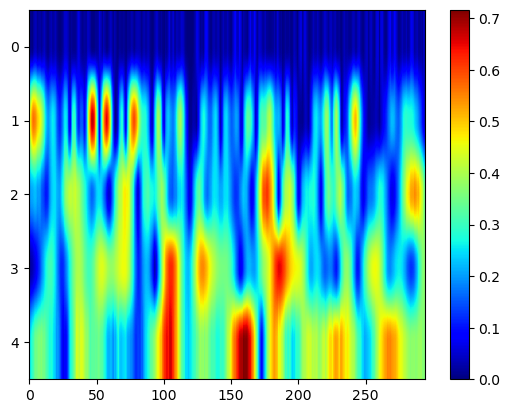

In [21]:
import matplotlib.pyplot as plt

R = 6
cwtmatr, freqs = pywt.cwt(np.concatenate(next(iter(itertools.permutations(raw_spec.values())))), list(range(1, R)), 'cmor4-1.0')
plt.imshow(np.absolute(cwtmatr),  cmap='jet', aspect='auto',vmax=np.absolute(cwtmatr).max(), vmin=0)
plt.colorbar()
plt.show()

In [22]:

import pywt

#random.seed(101)
lkey = random.choice(list(raw_spec.keys())) # shortest_key(raw_spec)
ctg1 = np.asarray(list(raw_spec[lkey]))

cnt = 0
M = 100
best_list = [lkey]
ctg = 0
while True:
    cnt +=1
    if cnt == 1:
        cwtmatr1, freqs = pywt.cwt(np.asarray(ctg1), list(range(1, M)), 'cmor4-1.0')
        ma1 = np.absolute(np.max(cwtmatr1))
        cwtmatr2, freqs = pywt.cwt(np.asarray(ctg1), list(range(1, M)), 'cmor4-1.0')
        ma2 = np.absolute(np.max(cwtmatr1))
    for k, v in raw_spec.items():
        if k in best_list: 
            continue
        #print(ctg1)
        #print("++++++++++++++++++++++++++++++++++")
        #print(ctg)
        #print(ctg1.shape)
        ctg = np.concatenate((ctg1, np.asarray(v)))
        cwtmatr1, freqs = pywt.cwt(np.asarray(ctg), list(range(1, M)), 'cmor4-1.0')
        if ma1 < np.absolute(np.max(cwtmatr1)):
            ma1 = np.absolute(np.max(cwtmatr1))
            best1 = (ma1, cwtmatr1, k, v)
        
        ctg = np.concatenate((np.asarray(v), ctg1))
        cwtmatr2, freqs = pywt.cwt(np.asarray(ctg), list(range(1, M)), 'cmor4-1.0')
        if ma2 < np.absolute(np.max(cwtmatr2)):
            ma2 = np.absolute(np.max(cwtmatr2))
            best2 = (ma2, cwtmatr2, k, v)
    
    #print(best1[0], best2[0])
    if best1[0] < best2[0]:
        ctg1 = np.concatenate((np.asarray(best2[3]),ctg1))
        if best_list[-1] == best2[2] : continue
        best_list.insert(len(best_list)-2, best2[2])

    else:
        ctg1 = np.concatenate((ctg1, np.asarray(best1[3])))
        if best_list[-1] == best1[2]: continue
        best_list.append(best1[2])
    print(best_list)
    if len(best_list) >= len(raw_spec):
        print(best_list)
        break
    
    #print(cnt)
    #if cnt % 10 == 0:
    #    print(cnt // 10)


['ce1_0', 'ce1_5']
['ce1_0', 'ce1_5', 'ce1_14']
['ce1_0', 'ce1_5', 'ce1_14', 'ce1_1']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_1']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_1', 'ce1_8']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4', 'ce1_7']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4', 'ce1_7', 'ce1_9']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4', 'ce1_7', 'ce1_9', 'ce1_3']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4', 'ce1_7', 'ce1_9', 'ce1_3', 'ce1_12']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4', 'ce1_7', 'ce1_9', 'ce1_3', 'ce1_12', 'ce1_6']
['ce1_0', 'ce1_5', 'ce1_2', 'ce1_14', 'ce1_13', 'ce1_1', 'ce1_8', 'ce1_4', 'ce1_7', 'ce1_9', 'ce1_3', 'ce1_12', 'ce1_6', 'ce1_11']
['ce1_0', 'ce1_5', 'ce1_2',

In [2]:
from multiprocessing import Pool, SimpleQueue, Process
import sys

q0 = SimpleQueue()
q = SimpleQueue()
r = 4
M = 50
kar = 99999999
targets = []
temp = []
data = 0
data2 = 0
thread = 3

def f(y):
    #print(y)
    for x in y:
        x = dict(x)
        cwtmatr, freqs = pywt.cwt(np.asarray(list(itertools.chain.from_iterable(x.values()))), list(range(1, M)), 'cmor4-1.0')
        ab = np.absolute(cwtmatr)
        maax = np.max(ab)
        q.put([list(x.keys()), ab, maax])

"""
def g(x):
    #print(dict(x))
    x = dict(x)
    cwtmatr, freqs = pywt.cwt(np.concatenate(list(x.values())), list(range(1, r+1)), 'cmor4-1.0')
    count = [i for i in list(np.absolute(cwtmatr[r-1])) if i > np.quantile(np.absolute(cwtmatr[r-1]), 0.95)]
    #print(len(count))
    if len(count) // 2 <= kar: 
        q0.put(list(x.items()))
"""

def iter_all():
    """
    #======================================================
    
    with Pool(thread) as p:
        p.map(g, itertools.permutations(raw_spec.items()))
    
    print("map1 complete")
    
    #=======================================================
    while not q0.empty():
        data = q0.get()
        targets.append(data)
    
    #print(len(targets))
    #print(targets[0])
    q0.close()
    print("selection complete")
    
    #=======================================================
    """
    targets = list(itertools.permutations(raw_spec.items()))
    processes = []
    jobs_per_thread = len(targets) // thread
    if jobs_per_thread == 0 :
        sys.exit(1)
    #print(jobs_per_thread)
    for i, po in enumerate(range(0, len(targets), jobs_per_thread)):
        #print(po, po+jobs_per_thread)
        p = Process(target=f, args=(targets[po:po+jobs_per_thread],))
        p.start()
    
    for po in processes:
        po.join()
    
    print("map2 complete")
    
    #=======================================================
    while not q.empty():
        data2 = q.get()
        #print(data2[0])
        temp.append(data2)
    
    #print("++++++++++++++++++++")
    q.close()
    #print("Escaped")
    #=======================================================
    for i, (ks, a, m) in enumerate(temp):
        if i == 0:
            ma = m
            best = ks
        else:
            if ma < m:
                ma = m
                best_matr = a
                best = ks

    #======================================================
    print(best)
    plt.imshow(best_matr, cmap='jet', aspect='auto',vmax=np.absolute(best_matr).max(), vmin=0) 
    plt.colorbar()
    plt.show()

if __name__ == "__main__":
    iter_all()

NameError: name 'itertools' is not defined

In [3]:
"""
import matplotlib.pyplot as plt

R = 40
cwtmatr, freqs = pywt.cwt(np.asarray(ctg1), list(range(1, R)), 'cmor4-1.0')
plt.imshow(np.absolute(cwtmatr),  cmap='jet', aspect='auto',vmax=np.absolute(cwtmatr).max(), vmin=0)
plt.colorbar()
plt.show()
#plt.savefig("./temptemp.jpg")
"""

'\nimport matplotlib.pyplot as plt\n\nR = 40\ncwtmatr, freqs = pywt.cwt(np.asarray(ctg1), list(range(1, R)), \'cmor4-1.0\')\nplt.imshow(np.absolute(cwtmatr),  cmap=\'jet\', aspect=\'auto\',vmax=np.absolute(cwtmatr).max(), vmin=0)\nplt.colorbar()\nplt.show()\n#plt.savefig("./temptemp.jpg")\n'

In [ ]:
#!cat ecoli23.fna | wc -l